## Visualization & Audio Examples

We visualize the input and reconstruction results.

In addition, we invert these **log-mel spectrograms to audios** using [`librosa.feature.inverse.mel_to_audio`](https://librosa.org/doc/main/generated/librosa.feature.inverse.mel_to_audio.html).


In [2]:
import sys
sys.path.append('..')
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from einops import rearrange
from IPython.display import display, Audio
import textwrap

from msm_mae.runtime import RuntimeMAE


# Create runtime instance
weight = '../80x512p16x16_0425/checkpoint-100.pth'
rt = RuntimeMAE(weight_file=weight)

80x512p16x16_0425
MaskedAutoencoderViT(patch size=(16, 16), grid_size=(5, 32),
  embed_dim=768, depth=12, num_heads=12, decoder_embed_dim=384,
  decoder_depth=4, decoder_num_heads=6, mlp_ratio=4,
  norm_pix_loss=False, use_cls_token=True, use_2d_dec_pos_embd=False)
Runtime MelSpectrogram(16000, 400, 400, 160, 80, 50, 8000):
MelSpectrogram(
  Mel filter banks size = (80, 201), trainable_mel=False
  (stft): STFT(n_fft=400, Fourier Kernel size=(201, 1, 400), iSTFT=False, trainable=False)
)


In [3]:
def attention_forward_w_attn(self, x):
    # Based on:
    # https://github.com/rwightman/pytorch-image-models/blob/7c67d6aca992f039eece0af5f7c29a43d48c00e4/timm/models/vision_transformer.py#L217
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x, attn

def block_forward_w_attn(self, x):
    # Based on:
    # https://github.com/rwightman/pytorch-image-models/blob/7c67d6aca992f039eece0af5f7c29a43d48c00e4/timm/models/vision_transformer.py#L245
    x_att, attn = attention_forward_w_attn(self.attn, self.norm1(x))
    x = x + self.drop_path(x_att)
    x = x + self.drop_path(self.mlp(self.norm2(x)))
    return x, attn


def vit_mae_forward_encoder(self, x, mask_ratio):
    # embed patches
    x = self.patch_embed(x)

    # add pos embed w/o cls token
    if self.use_cls_token:
        x = x + self.pos_embed[:, 1:, :]
    else:
        x = x + self.pos_embed

    # masking: length -> length * mask_ratio
    x, mask, ids_restore = self.random_masking(x, mask_ratio)

    # append cls token
    if self.use_cls_token:
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

    # apply Transformer blocks
    attmap = []
    for blk in self.blocks:
        x, attn = block_forward_w_attn(blk, x)
        attmap.append(attn)
    x = self.norm(x)

    return x, mask, ids_restore, torch.stack(attmap, dim=1)


In [4]:
class MAEViz:
    def __init__(self, runtime):
        self.device = next(iter(runtime.parameters()))[0].device
        self.runtime = runtime
        self.grid_size = self.runtime.backbone.grid_size()
        self.patch_size = self.runtime.backbone.patch_size()

    def to_spec(self, batch_audio):
        x, stats = self.runtime.to_normalized_spec(batch_audio, return_stats=True)
        self.last_norm_stats = stats
        return x
        
    def get_attention_map(self, batch_audio, start_frame=0):
        x = self.to_spec(batch_audio)

        # trim frames
        unit_frames = self.runtime.cfg.input_size[1]
        last_frame = start_frame + unit_frames
        x = x[..., start_frame:last_frame]

        _, mask, ids_restore, attmap = vit_mae_forward_encoder(self.runtime.backbone, x, 0.0)

        return x, mask, attmap

    def reconstruct(self, batch_audio, mask_ratio, start_frame=0):
        x = self.to_spec(batch_audio)

        # trim frames
        unit_frames = self.runtime.backbone.patch_embed.img_size[1]
        last_frame = start_frame + unit_frames
        x = x[..., start_frame:last_frame]
        # raw reconstruction
        with torch.no_grad():
            loss, recons, errormap, mask = self.runtime.backbone.forward_viz(x, mask_ratio)
        return loss, x, recons, errormap, mask


viz = MAEViz(rt)

In [5]:
import torchaudio


class BaseRawAudioDataset(torch.utils.data.Dataset):
    def __init__(self, cfg, tfms=None, random_crop=False):
        self.cfg = cfg
        self.tfms = tfms
        self.random_crop = random_crop

    def __len__(self):
        raise Exception('implement me')

    def get_audio(self, index):
        raise Exception('implement me')

    def get_label(self, index):
        return None # implement me

    def __getitem__(self, index):
        wav = self.get_audio(index) # shape is expected to be (cfg.unit_samples,)

        # Trim or stuff padding
        l = len(wav)
        unit_samples = self.cfg.unit_samples
        if l > unit_samples:
            start = np.random.randint(l - unit_samples) if self.random_crop else 0
            wav = wav[start:start + unit_samples]
        elif l < unit_samples:
            wav = F.pad(wav, (0, unit_samples - l), mode='constant', value=0)
        wav = wav.to(torch.float)

        # Apply transforms
        if self.tfms is not None:
            wav = self.tfms(wav)

        # Return item
        label = self.get_label(index)
        return wav if label is None else (wav, label)


class WavDataset(BaseRawAudioDataset):
    def __init__(self, cfg, audio_files, labels, tfms=None, random_crop=False):
        super().__init__(cfg, tfms=tfms, random_crop=random_crop)
        self.files = audio_files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def get_audio(self, index):
        filename = self.files[index]
        wav, sr = torchaudio.load(filename)
        assert sr == self.cfg.sample_rate, f'Convert .wav files to {self.cfg.sample_rate} Hz. {filename} has {sr} Hz.'
        return wav[0]

    def get_label(self, index):
        return None if self.labels is None else torch.tensor(self.labels[index])


def get_batch(cfg, files, seconds=5.12):
    files = list(files)
    cfg.unit_samples = int(cfg.sample_rate*seconds)
    ds = WavDataset(cfg, files, labels=None)
    return torch.stack([ds[i] for i in range(len(ds))])

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [6]:
print('Please download AudioSetWav16k_examples.zip and unzip here!')
print('Please download AudioSetWav16k_examples.zip and unzip here!')
print('Please download AudioSetWav16k_examples.zip and unzip here!')

Please download AudioSetWav16k_examples.zip and unzip here!
Please download AudioSetWav16k_examples.zip and unzip here!
Please download AudioSetWav16k_examples.zip and unzip here!


In [7]:
file_def = {
    'AudioSetWav16k/eval_segments/-0xzrMun0Rs_30.000.wav': 'Pop music with trumpet melody', # 13
    'AudioSetWav16k/eval_segments/-22tna7KHzI_28.000.wav': 'The sound of the wind roaring low', # 28
    'AudioSetWav16k/eval_segments/--U7joUcTCo_0.000.wav': 'Male laughing voice',
    'AudioSetWav16k/eval_segments/-1nilez17Dg_30.000.wav': 'Heartbeat followed by female speech', # 24
    'AudioSetWav16k/eval_segments/5hlsVoxJPNI_30.000.wav': 'Singing, do, re, mi, ...', # 2433
    'AudioSetWav16k/eval_segments/3tUlhM80ObM_0.000.wav': 'Knocking for five times', # 1836
}
batch = get_batch(rt.cfg, file_def.keys())
captions = list(file_def.values())
len(batch), len(captions)


(6, 6)

## Reconstruction results

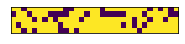

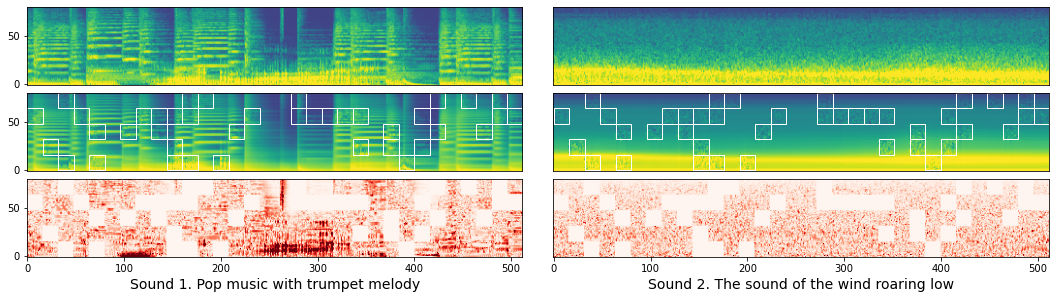

Sound 1. Pop music with trumpet melody: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 1. Pop music with trumpet melody: reconstruction (inverse.mel_to_audio())


Sound 2. The sound of the wind roaring low: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 2. The sound of the wind roaring low: reconstruction (inverse.mel_to_audio())


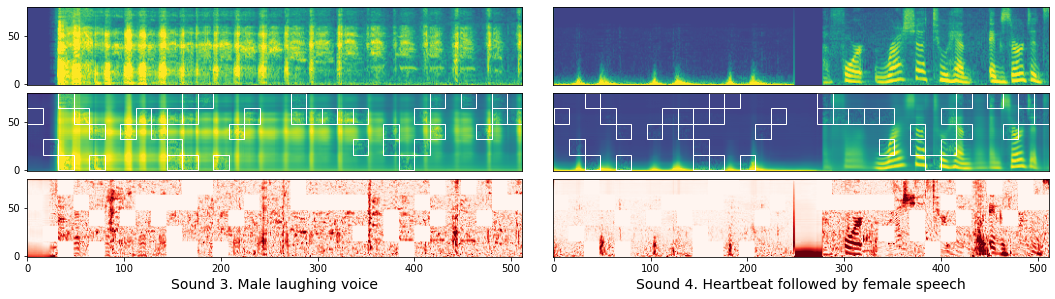

Sound 3. Male laughing voice: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 3. Male laughing voice: reconstruction (inverse.mel_to_audio())


Sound 4. Heartbeat followed by female speech: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 4. Heartbeat followed by female speech: reconstruction (inverse.mel_to_audio())


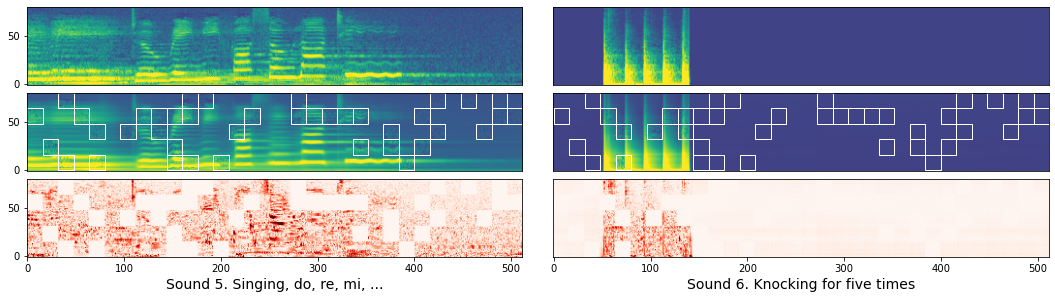

Sound 5. Singing, do, re, mi, ...: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 5. Singing, do, re, mi, ...: reconstruction (inverse.mel_to_audio())


Sound 6. Knocking for five times: input (once converted to LMS, then applied inverse.mel_to_audio())


Sound 6. Knocking for five times: reconstruction (inverse.mel_to_audio())


In [8]:
from IPython.display import Audio
import librosa


def play_recon(viz, lms, caption):
    mu, sigma = viz.last_norm_stats
    M = (lms*sigma + mu).exp().numpy()
    y = librosa.feature.inverse.mel_to_audio(M, sr=16000, n_fft=400, hop_length=160, win_length=400)
    display(Audio(y, rate=16000))
    print(caption)


def _recon_show(viz, mask, batch, captions, cols=3, figsize=(15, 7), n=None,
                input_visible=True, box_visible=True, errormap_visible=True, label_visible=True, label_chs=-1):
    rows_per_sample = 1 + input_visible + errormap_visible
    n = n or len(batch)
    rows = rows_per_sample * n // cols
    fig = plt.figure(figsize=(3, 2))
    plt.imshow(mask[0], origin='lower')
    plt.xticks([]); plt.yticks([])
    plt.show()

    _, org, recon, errormap, _ = viz.reconstruct(batch, mask.reshape((batch.shape[0], -1)))
    for r in range(0, rows, rows_per_sample):
        fig, axes = plt.subplots(nrows=rows_per_sample, ncols=cols, figsize=figsize)
        for c in range(cols):
            if c > 0:
                for dr in range(rows_per_sample):
                    axes[dr, c].get_yaxis().set_visible(False)
            idx = (r // rows_per_sample) * cols + c
            cur = 0
            caption = captions[idx] if label_chs < 0 else textwrap.shorten(captions[idx], label_chs, placeholder='...')
            caption = f'Sound {idx + 1}. {caption}'

            # input
            if input_visible:
                axes[cur, c].imshow(org[idx, 0], origin='lower', vmin=-2, vmax=2)
                axes[cur, c].get_xaxis().set_visible(False)
                cur += 1
            # reconstruction
            axes[cur, c].imshow(recon[idx, 0], origin='lower', vmin=-2, vmax=2)
            if errormap_visible or not label_visible: axes[cur, c].get_xaxis().set_visible(False)
            if not errormap_visible and label_visible: axes[cur, c].set_xlabel(caption, fontsize=14)
            pf, pt = viz.patch_size
            if box_visible:
                for f in range(viz.grid_size[0]):
                    for t in range(viz.grid_size[1]):
                        if mask[idx][f][t]: continue
                        axes[cur, c].add_patch(mpl_patches.Rectangle((pt*t, pf*f), pt, pf,
                            edgecolor = 'white',
                            fill=False, lw=1))
            cur += 1
            # errormap
            if errormap_visible:
                # print(pd.DataFrame(errormap.cpu().reshape(-1).numpy()).describe())
                axes[cur, c].imshow(errormap[idx, 0], cmap='Reds', origin='lower', vmin=0, vmax=1.0)
                if label_visible: axes[cur, c].set_xlabel(caption, fontsize=14)
                else:                   axes[cur, c].get_xaxis().set_visible(False)

        plt.tight_layout()
        plt.show()

        # playback
        for c in range(cols):
            idx = (r // rows_per_sample) * cols + c
            caption = captions[idx] if label_chs < 0 else textwrap.shorten(captions[idx], label_chs, placeholder='...')
            caption = f'Sound {idx + 1}. {caption}: '
            play_recon(viz, org[idx, 0], caption + 'input (once converted to LMS, then applied inverse.mel_to_audio())')
            play_recon(viz, recon[idx, 0], caption + 'reconstruction (inverse.mel_to_audio())')

    return org, recon


n_patches = viz.runtime.backbone.grid_size()[0] * viz.runtime.backbone.grid_size()[1]
n_masks = int(n_patches * 0.75)
mask = torch.tensor([True] * n_masks + [False] * (n_patches - n_masks))[torch.randperm(n_patches)]
mask = mask.reshape(viz.runtime.backbone.grid_size()).expand(batch.shape[0], -1, -1)
_ = _recon_show(viz, mask, batch, captions, figsize=(15, 4.2), cols=2, n=6, box_visible=True, errormap_visible=True, label_visible=True)